In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rand
import NSMap as ns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
from datetime import datetime

%load_ext autoreload
%autoreload 2

### Bring one Newport multiwindow and one Baltic Sea multiwindow analysis together into one figure
Most of the code in this notebook is copied from the Baltic Sea and Newport analysis notebooks, so refer to those for greater readability

In [9]:
filename = "../datasets/baltic_sea_mesocosm_transformed.csv"

df = pd.read_csv(filename, encoding="utf-8", na_filter=False)
table = df.to_numpy()

In [10]:
def makeHeatMapBaltic(results):
    nonstationarityHeatMap = np.zeros((29,29)) * np.nan
    for l, o, d, t, r in results:
        i_length = 27-(int(l / year_steps) - 2)
        i_offset = int(o / year_steps)
        # print(i_length, i_offset)
        nonstationarityHeatMap[i_length, i_offset] = d
        
    return nonstationarityHeatMap

def makeFigureBaltic(nonstationarityHeatMap, ts, name, ax):
    scaling = lengths[-1] *3.35 / 365
    
    im = ax.imshow(np.log(nonstationarityHeatMap[:-2]+1), cmap=custom_cmap)
    ax.set_xticks(np.arange(31,step = 30 / scaling))
    ax.set_yticks(30-365*np.arange(1,8)/3.35/26) # DON'T TOUCH THIS LINE
    ax.set_xticklabels([])
    ax.set_yticklabels(np.arange(1,8))
    ax.set_ylim(27,-1)
    ax.set_xlim(-1.3,32)
    
    ax.set_ylabel("Time series length (years)",fontsize=15)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=15)

    axTS = divider.append_axes('bottom', size='30%', pad=0.1)

    axTS.plot(table[:,0]/365, ts,c="dodgerblue")
    axTS.set_ylabel(name, fontsize = 15)
    axTS.set_xlabel("Start year",fontsize=15)
    axTS.set_yticks([])

    # plt.savefig(f"../Figures/baltic_sea_multiwindow_analysis/{name}_multiwindow.png", dpi=300)
    # plt.show()

In [11]:
def makeHeatMapNewport(results):
    nonstationarityHeatMap = np.zeros((25,25)) * np.nan
    for l, o, d, t, r in results:
        i_length = 24-(int(l/12) - 2)
        i_offset = int(o/12)
        nonstationarityHeatMap[i_length, i_offset] = d
    
    return nonstationarityHeatMap

def makeFigureNewport(nonstationarityHeatMap, ts, name, ax):
    # fig, ax = plt.subplots(1,figsize=(13,10))
    # fig, ax = plt.subplots(1,figsize=(8,8))
    im = ax.imshow(np.log(nonstationarityHeatMap[:-3]+1), cmap=custom_cmap)
    ax.set_xticks(np.arange(0,26+1,step=2))
    ax.set_xlim(-1.08,27.7)

    ax.set_ylabel("Time series length (years)",fontsize=15)
    ax.set_yticks(np.arange(-1,22+1))
    ax.set_yticklabels(np.flip(np.hstack([np.arange(4,25+1)+1,""])))

    # drawBracket(2008, 9, ax)
    # drawBracket(2014, 8, ax)
    # drawBracket(1996, 26, ax)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=15)

    axTS = divider.append_axes('bottom', size='30%', pad=0.1)

    axTS.plot(np.linspace(1996.264,2022.335,num=312), ts,c="dodgerblue")
    axTS.set_xticks(np.arange(1996,2022+1,step=2))
    axTS.set_yticks([])
    axTS.set_ylabel(f"{name}", fontsize = 15, style = "italic")
    axTS.set_xlabel("Start year",fontsize=15)

    # plt.savefig(f"../Figures/newport_multiwindow_analysis/{name}_multiwindow.png", dpi=300)

def drawBracket(start_year, length, ax):
    start_index = start_year - 1996
    length_index = 26 - length
    ax.plot(np.array([start_index, start_index + length ]),
            np.ones(2)*length_index, c="black")

In [12]:
orange_rgba = colors.to_rgba("orange")
dodgerblue_rgba = colors.to_rgba("dodgerblue")
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [dodgerblue_rgba, orange_rgba])
custom_cmap.set_bad("white", 1)

0.92332


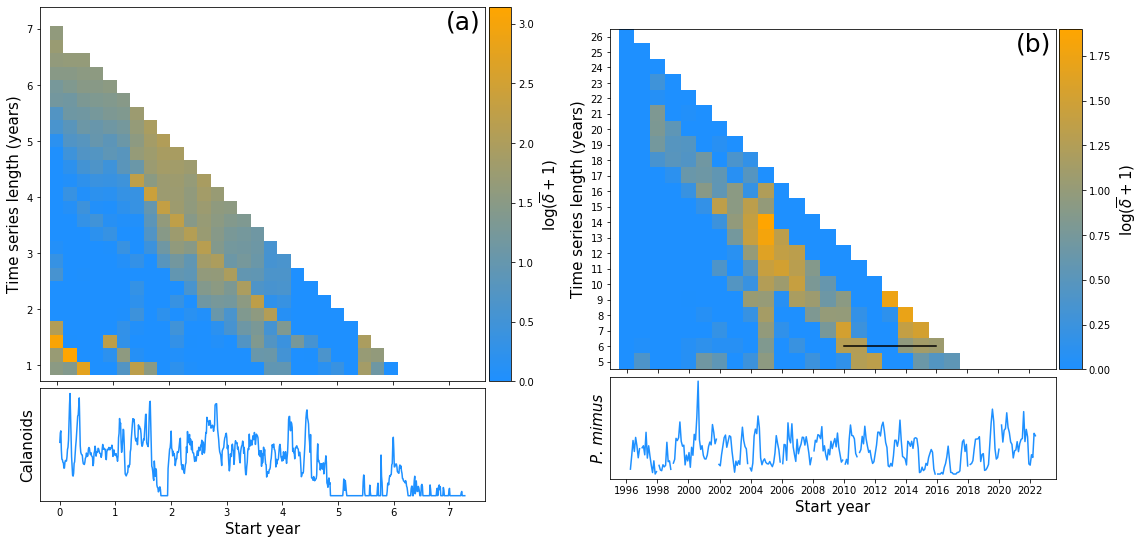

In [13]:
text_padding = 0.01 # -0.075

# Newport
filename = "../datasets/baltic_sea_mesocosm_transformed.csv"

df = pd.read_csv(filename, encoding="utf-8", na_filter=False)
table = df.to_numpy()

fig, ax = plt.subplots(1, 2, figsize=(16,8))

index = 0
year_steps = 27

species_baltic = "Calanoids"
results = np.loadtxt(f"../results/baltic_sea_multiwindow/{species_baltic}_time_window.csv",
                     delimiter=",")
lengths = np.unique(results[:,0])

print(results[-1,4])

ts = ns.standardize(table[:,index+1])
nonstationarityHeatMap = makeHeatMapBaltic(results)
makeFigureBaltic(nonstationarityHeatMap, ts, species_baltic, ax[0])

# Pseudocalanus
results = np.loadtxt("../results/newport_multiwindow/pseudocalanus_time_window.csv", delimiter=",")

# Load the time series for Pseudocalanus, the most abundant Newport species
table = np.loadtxt("../datasets/newport_aggregated_series.csv", delimiter=",")
ts = table[:,0]

nonstationarityHeatMap = makeHeatMapNewport(results)
makeFigureNewport(nonstationarityHeatMap, ts, "P. mimus", ax[1])

ax[0].text(1 - text_padding, 1 - text_padding, "(a)", size=25, rotation=0, 
            horizontalalignment="right", verticalalignment="top",
            transform=ax[0].transAxes)
ax[1].text(1 - text_padding, 1 - text_padding, "(b)", size=25, rotation=0, 
            horizontalalignment="right", verticalalignment="top",
            transform=ax[1].transAxes)

drawBracket(2010, 6, ax[1])

plt.tight_layout()
plt.savefig("../figures_eps/Figure_5.eps", format="eps", bbox_inches="tight")